In [115]:
import polars as pl

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets


In [116]:
set_config(transform_output='polars')

df = pl.read_csv('datasets/titanic_train.csv')
df = df.rename({col: col.lower() for col in df.columns})

In [117]:
columns = ['age', 'fare', 'parch']
dropdown = widgets.Dropdown(options=columns, value=columns[0])

def plot(column):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # sns.lineplot(data=df, x=column, y='survived')
    sns.kdeplot(data=df, x=column, hue='survived', ax=axes[0])
    sns.boxplot(data=df, x=column, hue='survived', ax=axes[1], showfliers=False)
    plt.show()
    agg_df = (
        df.group_by('survived')
            .agg([
                pl.col(column).quantile(0.25).alias('25%'),
                pl.col(column).median().alias('median'),
                pl.col(column).quantile(0.75).alias('75%'),])
            .sort('survived')
    )
    print(agg_df)

widgets.interact(plot, column=dropdown)


interactive(children=(Dropdown(description='column', options=('age', 'fare', 'parch'), value='age'), Output())…

<function __main__.plot(column)>

In [156]:
cat_columns = ["embarked", "sex", "pclass"]
dropdown = widgets.Dropdown(options=columns, value=cat_columns[0])

def plot(column):
    agg_df = (
        df.group_by(column, null_handling='include')
            .agg([
                pl.sum('survived').alias('survived'),
                pl.count('survived').alias('total'),
                (pl.sum('survived') / pl.count('survived')).alias('survival_rate')
            ])
            .sort(column)
    )

    sns.barplot(data=agg_df, x=column, y='survival_rate')
    plt.show()
    print(agg_df)

widgets.interact(plot, column=dropdown)

interactive(children=(Dropdown(description='column', options=('embarked', 'sex', 'pclass'), value='embarked'),…

<function __main__.plot(column)>

In [181]:
relevant_df = df.select(
    pl.col('age').fill_null(strategy='mean'),
    pl.col('fare').fill_null(strategy='mean'),
    pl.col('survived'),
)
print('correlation with survived:')
print(relevant_df.corr()[2])
# sns.heatmap(correlation_matrix, annot=True, cmap='PuOr')

correlation with survived:
shape: (1, 3)
┌───────────┬──────────┬──────────┐
│ age       ┆ fare     ┆ survived │
│ ---       ┆ ---      ┆ ---      │
│ f64       ┆ f64      ┆ f64      │
╞═══════════╪══════════╪══════════╡
│ -0.069809 ┆ 0.257307 ┆ 1.0      │
└───────────┴──────────┴──────────┘


In [118]:
x_df = df.drop('survived')
y_df = df['survived']
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_df, y_df, stratify=y_df, random_state=0)
x_train_df

passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
i64,i64,str,str,f64,i64,i64,str,f64,str,str
672,1,"""Davidson, Mr. Thornton""","""male""",31.0,1,0,"""F.C. 12750""",52.0,"""B71""","""S"""
418,2,"""Silven, Miss. Lyyli Karoliina""","""female""",18.0,0,2,"""250652""",13.0,null,"""S"""
635,3,"""Skoog, Miss. Mabel""","""female""",9.0,3,2,"""347088""",27.9,null,"""S"""
324,2,"""Caldwell, Mrs. Albert Francis …","""female""",22.0,1,1,"""248738""",29.0,null,"""S"""
380,3,"""Gustafsson, Mr. Karl Gideon""","""male""",19.0,0,0,"""347069""",7.775,null,"""S"""
…,…,…,…,…,…,…,…,…,…,…
132,3,"""Coelho, Mr. Domingos Fernandeo""","""male""",20.0,0,0,"""SOTON/O.Q. 3101307""",7.05,null,"""S"""
491,3,"""Hagland, Mr. Konrad Mathias Re…","""male""",null,1,0,"""65304""",19.9667,null,"""S"""
529,3,"""Salonen, Mr. Johan Werner""","""male""",39.0,0,0,"""3101296""",7.925,null,"""S"""


In [184]:
ct = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), ["age", "fare"]),
    (OneHotEncoder(sparse_output=False), ["embarked", "sex", "pclass"]),
    verbose_feature_names_out=False)


# Note: click on pipeline elements to see more details
classifiers = {
    'logistic_regression': LogisticRegression(),
    'stochastic_gradient_descent': SGDClassifier(loss='log_loss'),
    'random_forest': RandomForestClassifier(),
    'xgboost': XGBClassifier() # see https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn for more parameters
}

def run_pipeline_with_classifier(clf_name):
    clf = make_pipeline(ct, classifiers[clf_name])
    clf.fit(x_train_df, y_train_df)
    print('solver:', clf_name)
    print(clf.score(x_test_df, y_test_df))

classifiers_selector = widgets.Dropdown(options=classifiers.keys(), value='logistic_regression')
widgets.interact(run_pipeline_with_classifier, clf_name=classifiers_selector)

# for clf_name in classifiers:
#     run_pipeline_with_classifier(clf_name)
#     print()

interactive(children=(Dropdown(description='clf_name', options=('logistic_regression', 'stochastic_gradient_de…

<function __main__.run_pipeline_with_classifier(clf_name)>

In [194]:
n_estimators_widget = widgets.IntSlider(value=100, min=0, max=300, step=5)
max_depth_widget = widgets.IntSlider(min=1, max=20, step=1)

print('Performance of Random Forest with different hyperparameters:')
def run_pipeline_with_random_forest(n_estimators, max_depth):
    clf = make_pipeline(ct, RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth))
    clf.fit(x_train_df, y_train_df)
    print(clf.score(x_test_df, y_test_df))

widgets.interact(run_pipeline_with_random_forest, n_estimators=n_estimators_widget, max_depth=max_depth_widget)


Performance of Random Forest with different hyperparameters:


interactive(children=(IntSlider(value=100, description='n_estimators', max=300, step=5), IntSlider(value=1, de…

<function __main__.run_pipeline_with_random_forest(n_estimators, max_depth)>

In [201]:
max_iter_widget = widgets.IntSlider(value=40, min=20, max=100, step=5)

print('Performance of Logistic Regression with different hyperparameters:')
def run_pipeline_with_logistic(max_iter):
    clf = make_pipeline(ct, LogisticRegression(max_iter=max_iter))
    clf.fit(x_train_df, y_train_df)
    print(clf.score(x_test_df, y_test_df))

widgets.interact(run_pipeline_with_logistic, max_iter=max_iter_widget)


Performance of Logistic Regression with different hyperparameters:


interactive(children=(IntSlider(value=40, description='max_iter', min=20, step=5), Output()), _dom_classes=('w…

<function __main__.run_pipeline_with_logistic(max_iter)>

In [153]:
clf = make_pipeline(ct, LogisticRegression())
clf.fit(x_train_df, y_train_df)
clf.score(x_test_df, y_test_df)

0.7847533632286996

score:  0.7847533632286996


<Axes: >

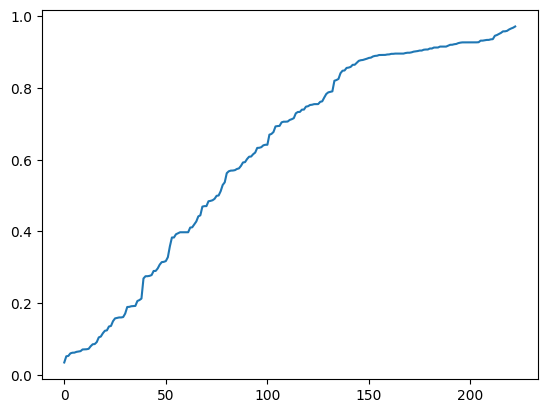

In [154]:
prob = clf.predict_proba(x_test_df)
print('score: ', clf.score(x_test_df, y_test_df))
prob_df = pl.DataFrame({str(clf.classes_[i]): list(prob[:, 0]) for i in range(len(clf.classes_))})['1']
prob_df
sns.lineplot(data=prob_df.sort())